In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import csv
import pandas as pd
from IPython.display import display, HTML

First we create arrays  : SubR contains all the differents Sub Reddit, Users_SubR : the first value of each row is the user and the rest are the subreddit he is active in.

In [2]:
Data = open('reddit-user-posting-behavior.csv', "r") #opening ths csv file
Reader = csv.reader(Data, delimiter=',') #creating a reader for the data
i = 0
Users_SubR = np.full([876961,125],None) #empty array that will contain the data of the csv file
SubR = [] #array that will contains the differents subreddits

for row in Reader : #for each row / user : 
    j = 0
    for col in row :     #for each column  / subreddit : 
        Users_SubR[i][j] = row[j]  #putting all the datas of the csv file in the array 
        if j != 0 : 
            if row[j] not in SubR : #if the subreddit is not in the array of subreddits
                SubR.append(row[j])  #add the subreddit to the array of subreddits
        j= j+1
    i = i+1

Then we can create the X matrix

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

X_sparse = []   #create a simple array
Sum_SR = np.full(15122,0) #and an empty array for the number of users in the subreddits
i=0
j=1
for i in range(0,876961) : #for all the users : 
    j=1
    while Users_SubR[i][j] != None : #while the users has subreddits : 
        index = SubR.index(Users_SubR[i][j]) #we get the index of the subreddit the user is active in the subreddit array
        Sum_SR[index] +=1 #add 1 user for the subreddit 
        triplet = [index, i, 1] #create a triplet, 1 if the user 'i'  is active in subreddit 'index'
        X_sparse.append(triplet) #and add it in the array
        j = j+1


In [4]:
rows, cols, vals = zip(*X_sparse)
X = csr_matrix((vals, (rows, cols))) #now we can create the sparse matrix with the previous array

Now we can create Xtranspose and G = X * Xtranspose

In [5]:
Xtransp = X.transpose()
G = X @ Xtransp #compute G with X and its transpose

Now we can create P

In [6]:
P = lil_matrix((15122,15122)) #P is first a lil_matrix to compute faster
for i in range(0,15122) : #for each subreddit
    P[i] = G[i] / Sum_SR[i] #divide P by the number of users in the subreddit
P = P.tocsr()
P = csr_matrix(P.toarray()) #transform P to array and then to sparse matrix to get the 0 out if needed

We can now create the final matrix M : 

In [7]:
P.data = np.where(P.data < 0.05,0,P.data) #threshold the matrix at 5% = 0.05
Ptransp = P.transpose()
M = P.multiply(Ptransp) #compute M equals to P multiplied by its transpose
for i in range(0,15122) : #we eliminate the inconsistent data
    M[i,i] = 0
M = csr_matrix(M.toarray()) #transform M to array and then to sparse matrix to get the 0 out

And plot it :

In [8]:
AT = nx.Graph() #Create a networkx graph
AT = nx.from_scipy_sparse_matrix(M) #apply the sparse matrix to the graph
nx.write_gml(AT, "afterthreshold.gml") #export the graph for illustration

We only keep the connected graph, removing nodes without edges :

In [9]:
Sub_Graph = [AT.subgraph(c).copy() for c in nx.connected_components(AT)] #create subgraph to keep only connected nodes
Final = Sub_Graph[0]  #we get our final graph
nx.write_graphml(Final, "final.graphml") #export the graph for illustration

# Question 1

In [10]:
#Computing and printing the different datas we want
print("Number of edges: ",Final.number_of_edges())
print("Number of nodes: ",Final.number_of_nodes())
print("Diameter: ",nx.diameter(Final))

print("Average clustering coefficient: ", nx.average_clustering(Final))
        
deg_centrality = sum(nx.degree_centrality(Final).values())
average_deg_centrality = deg_centrality/len(nx.degree_centrality(Final).values()) #computing average with sum / number of values
print("Average degree centrality: ",average_deg_centrality)

print("Number of components: ",nx.number_connected_components(Final))

Number of edges:  14806
Number of nodes:  6379
Diameter:  30
Average clustering coefficient:  0.3228488403661757
Average degree centrality:  0.0007278311246956944
Number of components:  1


# Question 2

In [11]:
Centralities = np.full([Final.number_of_nodes(),3], None) #create empty array to store the data

Deg_Cent = nx.degree_centrality(Final) #computing the centralities measures
Bet_Cent = nx.betweenness_centrality(Final)
Clo_Cent = nx.closeness_centrality(Final)

for i in range(Final.number_of_nodes()): #and putting them in the array :
    Centralities[i][0] = Deg_Cent.get(i) #degree
    Centralities[i][1] = Bet_Cent.get(i) #betweenness    
    Centralities[i][2] = Clo_Cent.get(i) #closeness

Now we can plot the graph : 

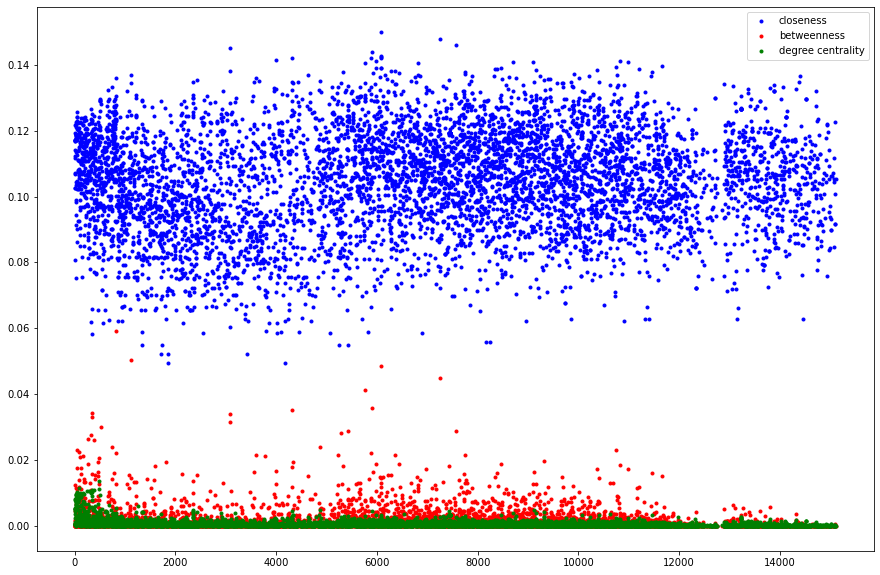

In [12]:
plt.rcParams['figure.figsize'] = (15,10)
plt.plot(Final.nodes(),Clo_Cent.values(),'bo', ms=3, label='closeness')
plt.plot(Final.nodes(),Bet_Cent.values(),'ro',ms=3,label='betweenness')
plt.plot(Final.nodes(),Deg_Cent.values(),'go',ms=3,label='degree centrality')
plt.legend()
plt.show() #plotting the graph

# Question 3

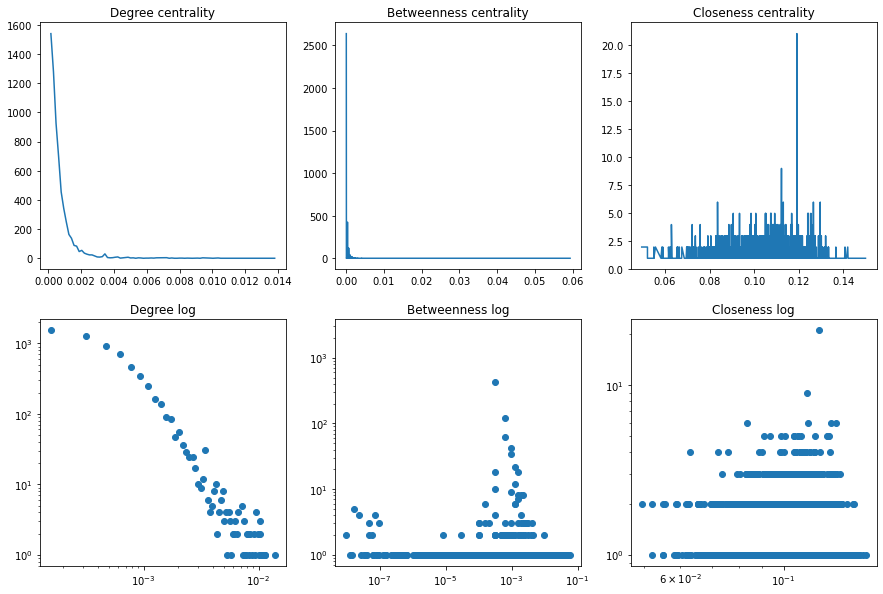

In [13]:
from collections import defaultdict
#now we compute the frequency of each value in the dicts : 
freq1 = defaultdict(float)
freq2 = defaultdict(float)
freq3 = defaultdict(float)
for key, val in Deg_Cent.items():
    freq1[val] += 1
for key, val in Bet_Cent.items():
    freq2[val] += 1
for key, val in Clo_Cent.items():
    freq3[val] += 1

lists1 = sorted(freq1.items()) # sorted by key, return a list of tuples
lists2 = sorted(freq2.items())
lists3= sorted(freq3.items()) 

x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
x2, y2 = zip(*lists2) 
x3, y3 = zip(*lists3) 

#and plot them in different graphs : 
plt.subplot(2,3,1)
plt.plot(x1, y1)
plt.title("Degree centrality")
plt.subplot(2,3,2)
plt.plot(x2, y2)
plt.title("Betweenness centrality")
plt.subplot(2,3,3)
plt.plot(x3, y3)
plt.title("Closeness centrality")
plt.subplot(2,3,4)
plt.loglog(x1,y1,'o')
plt.title("Degree log")
plt.subplot(2,3,5)
plt.loglog(x2,y2,'o')
plt.title("Betweenness log")
plt.subplot(2,3,6)
plt.loglog(x3,y3,'o')
plt.title("Closeness log")
plt.show()

# Question 8

In [14]:
commu = nx.algorithms.community.label_propagation_communities(Final) #algorithm to create communities
communities = [] #empty array to contain the communities
i=0
for key in commu : #for each community : 
    community = [] #empty array
    for item in key : #for each node : 
        community.append(item) #add the node to the community
    communities.append(community) #add the community to the communities array
print("Number of communities : ",len(communities))

Number of communities :  1311


In [15]:
commu_nodes = np.full(1311,0)
commu_edges = np.full(1311,0)
commu_clust_coeff = np.full(1311,0.0)
commu_diam = np.full(1311,0) #creating empty arrays before computing
i=0  

for coms in communities : #for each community : 
    G = Final.subgraph(coms) #create a subgraph of the community
    commu_nodes[i] = G.number_of_nodes()
    commu_edges[i] = G.number_of_edges()
    commu_clust_coeff[i]  = nx.average_clustering(G)
    if nx.is_connected(G) : 
        commu_diam[i] = nx.diameter(G) #computing everything we want for each community / subgraph
    i+=1

In [16]:
from tabulate import tabulate

commu_summarize = np.full([1311,5],None)
for i in range(len(communities)) :  #creating an array with all the previously computed values : 
    commu_summarize[i,0] = i
    commu_summarize[i,1] = commu_nodes[i]
    commu_summarize[i,2] = commu_edges[i]
    commu_summarize[i,3] = commu_clust_coeff[i]
    commu_summarize[i,4] = commu_diam[i]
    
    
df1 = pd.DataFrame({"id of community" : (row[0] for row in commu_summarize),
                   "Number of nodes" : (row[1] for row in commu_summarize),
                   "Number of edges" : (row[2] for row in commu_summarize),
                  "Clustering Coefficient" : (row[3] for row in commu_summarize),
                  "Diameter" : (row[4] for row in commu_summarize)})
display(HTML(df1.to_html()))

,id of community,Number of nodes,Number of edges,Clustering Coefficient,Diameter
0,0,132,1250,0.554354,7
1,1,5,5,0.433333,2
2,2,30,78,0.496098,7
3,3,6,10,0.833333,2
4,4,153,920,0.520546,7
5,5,4,4,0.583333,2
6,6,14,31,0.544527,3
7,7,12,18,0.405556,0
8,8,8,15,0.687500,3
9,9,3,2,0.000000,2


# Question 9

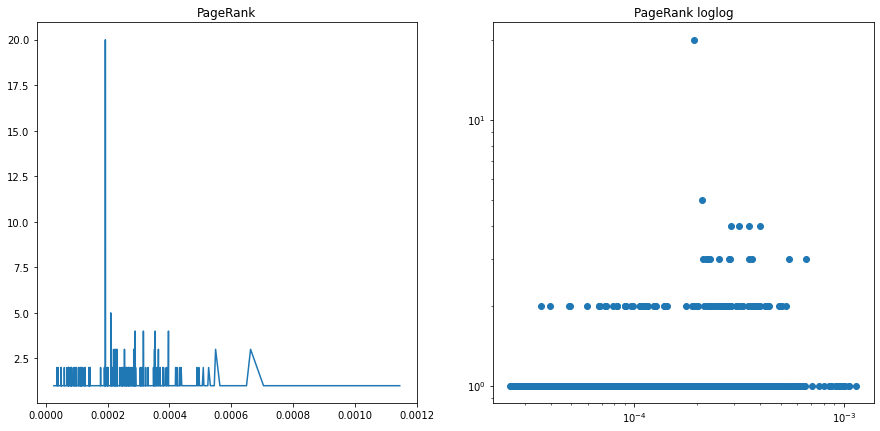

In [17]:
from collections import defaultdict

PageRank = nx.pagerank(Final) #computing the pagerank valies of each node 

freq = defaultdict(float)
for key, val in PageRank.items():
    freq[val] += 1
lists = sorted(freq.items())
x, y = zip(*lists) #same method as before to get the frequency and plotting it

plt.rcParams['figure.figsize'] = (15,7)
plt.subplot(1,2,1)
plt.plot(x, y)
plt.title("PageRank")
plt.subplot(1,2,2)
plt.loglog(x,y,'o')
plt.title("PageRank loglog")
plt.show()

In [18]:
commu_PR = np.full([1311,2],None)
i=0

PR =  nx.pagerank(AT) #computing the pagerank of all the nodes of the graph
data = list(PR.values()) #creating a list of the pagerank values
    
for coms in communities : #for each community : 
    G = Final.subgraph(coms) #subgraph of the community
    nodes = G.nodes()
    commu_PR[i,0] = i
    commu_PR[i,1] = sum(np.take(data,nodes)) #sum of the pagerank values of the nodes of the subgraph
    i+=1

In [19]:
Ranked_commu_PR = np.full([1311,2],None) #array for the sorted communities array 
Ranked_commu_PR =commu_PR[(-commu_PR[:,1]).argsort()] #get the communities and pagerank, sort the array by pagerank values
#now we put the data in a pandas dataframe and diqplay it :
df2 = pd.DataFrame({"id of community" : (row[0] for row in Ranked_commu_PR), "PageRank centrality" : (row[1] for row in Ranked_commu_PR)})
display(HTML(df2.to_html()))

,id of community,PageRank centrality
0,0,0.023447
1,4,0.019297
2,377,0.010297
3,48,0.007401
4,49,0.006811
5,280,0.006612
6,13,0.005736
7,145,0.005355
8,567,0.003879
9,921,0.003719


In [20]:
import copy
communities_names = copy.deepcopy(communities) #copying the communities array
i=0
for coms in communities : #for each community : 
    j=0
    for j in range(len(coms)) : #for each node : 
        val = communities[i][j] #get the id of the node
        communities_names[i][j] = SubR[val] #remplacing the id by the name of the community
    i+=1

# Pop culture : 0
# Learn : 4
# Music : 19
# Fitness : 6
#print(communities_names[4])